# Experiments on Inception algorithm

The idea of this notebook is to understand and test the Inception algorithm locally on a few samples.

In [18]:
import pandas as pd
import numpy as np
from utility_functions import log_progress
import matplotlib.pyplot as plt

CSV_LINK = "../data/raw/RAISE_6k.csv"
MODEL_SAVE_PATH = "../models/trained_model_test"
IMAGE_SIZE = (700, 700)
DATASET_TRAIN_SIZE = 50
DATASET_TEST_SIZE = 15
EPOCHS_NB = 3
BATCH_SIZE = 10
STEPS_PER_EPOCH = 10
VALIDATION_RATIO = 0.1
VALIDATION_STEPS = 5

# For image augmentation
ROTATION_RANGE = 15
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2
BRIGHTNESS_RANGE = (0.5, 1)
SHEAR_RANGE = 0.1
ZOOM_RANGE = 0.2
HORIZONTAL_FLIP = True

## Pictures download and preprocessing

Here we will download some pictures and extract their label people/not people (50, in a balanced dataset).

In [3]:
import requests

DATASET_SIZE = DATASET_TRAIN_SIZE + DATASET_TEST_SIZE

First we extract from the dataframe:
- The file name
- The download link
- The people label

In [4]:
df = pd.read_csv(CSV_LINK)
df["People"] = df["Keywords"].map(lambda keywordsStr : float('people' in keywordsStr))
df["Class"] = df["People"].map(lambda is_people : "people" if is_people else "not_people")
df["FileName"] = df["File"].map(lambda file_name : "image_" + file_name + ".tif")
df = df[["FileName", "TIFF", "People", "Class"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  6000 non-null   object 
 1   TIFF      6000 non-null   object 
 2   People    6000 non-null   float64
 3   Class     6000 non-null   object 
dtypes: float64(1), object(3)
memory usage: 187.6+ KB


Then we select the correct number of images.

In [5]:
df_not_people = df[df["People"] == 0]
df_people = df[df["People"] == 1]
df_final = pd.concat([df_not_people.iloc[:DATASET_SIZE//2], df_people.iloc[:DATASET_SIZE//2]])
df_final = df_final.sample(frac=1).reset_index(drop=True)
df_final

FileName                                              TIFF  \
0   image_r04108c64t.tif  http://193.205.194.113/RAISE/TIFF/r04108c64t.TIF   
1   image_r0428df0ct.tif  http://193.205.194.113/RAISE/TIFF/r0428df0ct.TIF   
2   image_r05772356t.tif  http://193.205.194.113/RAISE/TIFF/r05772356t.TIF   
3   image_r0207a52ct.tif  http://193.205.194.113/RAISE/TIFF/r0207a52ct.TIF   
4   image_r072d955bt.tif  http://193.205.194.113/RAISE/TIFF/r072d955bt.TIF   
..                   ...                                               ...   
59  image_r006fcc20t.tif  http://193.205.194.113/RAISE/TIFF/r006fcc20t.TIF   
60  image_r00b3931bt.tif  http://193.205.194.113/RAISE/TIFF/r00b3931bt.TIF   
61  image_r02d732f8t.tif  http://193.205.194.113/RAISE/TIFF/r02d732f8t.TIF   
62  image_r03f70ccdt.tif  http://193.205.194.113/RAISE/TIFF/r03f70ccdt.TIF   
63  image_r042d7b17t.tif  http://193.205.194.113/RAISE/TIFF/r042d7b17t.TIF   

    People       Class  
0      1.0      people  
1      1.0      people  
2      1.0      people  
3      1.0      people  
4      1.0      people  
..     ...         ...  
59     0.0  not_people  
60     0.0  not_people  
61     1.0      people  
62     1.0      people  
63     1.0      people  

[64 rows x 4 columns]

Now we can download the images

In [6]:
def get_file_path(file_name):
    return "../data/raw/pictures/" + file_name

def download_images():
    for index, row in log_progress(df_final.iterrows(), size=df_final.shape[0]):
        if not os.path.isfile(get_file_path(row["FileName"])):
            response = requests.get(row["TIFF"])
            file = open(get_file_path(row["FileName"]), 'wb')
            file.write(response.content)
            file.close()

download_images()

## Preprocessing

The goal of this part is to preprocess data that we will use in Keras.

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

Inception V3 takes in images of size we want.

It also provides a function to preprocess images (by scaling pixel values between -1 and 1).

We can also do some data augmentation here.

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    validation_split=VALIDATION_RATIO,
    preprocessing_function=preprocess_input
    )

train_generator = train_datagen.flow_from_dataframe(
    df_final.iloc[:DATASET_TRAIN_SIZE], 
    directory="../data/raw/pictures", 
    x_col="FileName",
    y_col="Class",
    target_size=IMAGE_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="training")

validation_generator = train_datagen.flow_from_dataframe(
    df_final.iloc[:DATASET_TRAIN_SIZE],
    directory="../data/raw/pictures", 
    x_col="FileName",
    y_col="Class",
    target_size=IMAGE_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset='validation')

Found 45 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


On the testing step we don't need data augmentation.

In [9]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

test_generator = test_datagen.flow_from_dataframe(
    df_final.iloc[DATASET_TRAIN_SIZE:], 
    directory="../data/raw/pictures", 
    x_col="FileName",
    y_col="Class",
    target_size=IMAGE_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE)

Found 14 validated image filenames belonging to 2 classes.


## Build model

Here we will import Inception V3 and add custom layers on top

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers

First we import InceptionV3 without its top layer.

We put all its layers as non trainable because we don't want to update its weights.

In [11]:
inception_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), pooling="avg")
for layer in inception_model.layers:
	layer.trainable = False
print("Model structure: ", inception_model.summary())

__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 42, 42, 192)  576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 42, 42, 192)  576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 42, 42, 192)  576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 42, 42, 192)  576         conv2d_69[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 42, 42, 192)  0           batch_normalization_60[0][0]     
__________

In [12]:
# Nb of layers
print("Nb of layers: ", len(inception_model.layers), "\n")

# Entry layer
print("Entry layer: ", inception_model.layers[0], " with ", inception_model.layers[0].input_shape, " input shape.\n")

# Last layers
print("Before last layer: ", inception_model.layers[-2], " with ", inception_model.layers[-2].output_shape, " output shape.")
print("Last layer: ", inception_model.layers[-1], " with ", inception_model.layers[-1].output_shape, " output shape.")

Nb of layers:  312 

Entry layer:  <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1a40974590>  with  [(None, 700, 700, 3)]  input shape.

Before last layer:  <tensorflow.python.keras.layers.merge.Concatenate object at 0x1a4224d5d0>  with  (None, 20, 20, 2048)  output shape.
Last layer:  <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x1a4224d690>  with  (None, 2048)  output shape.


Then we add some layers on top that we will train to predict id there are people in images.

We put all Inception layers as non trainable because we don't want to update its weights.

In [13]:
output = layers.Dense(1, activation='sigmoid')(inception_model.layers[-1].output)
model = Model(inputs=inception_model.inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training

The goal of this part is to try to use Inception V3.

In [14]:
# Nb of layers
print("Nb of layers: ", len(model.layers), "\n")

# Entry layer
print("Entry layer: ", model.layers[0], " with ", model.layers[0].input_shape, " input shape.\n")

# Last layers
print("Last layer from Inception: ", model.layers[-3], " with ", model.layers[-3].output_shape, " output shape.")
print("First additional layer: ", model.layers[-2], " with ", model.layers[-2].output_shape, " output shape.")
print("Second additional layer: ", model.layers[-1], " with ", model.layers[-1].output_shape, " output shape.")

Nb of layers:  313 

Entry layer:  <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1a40974590>  with  [(None, 700, 700, 3)]  input shape.

Last layer from Inception:  <tensorflow.python.keras.layers.merge.Concatenate object at 0x1a4224d5d0>  with  (None, 20, 20, 2048)  output shape.
First additional layer:  <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x1a4224d690>  with  (None, 2048)  output shape.
Second additional layer:  <tensorflow.python.keras.layers.core.Dense object at 0x1a470d0c50>  with  (None, 1)  output shape.


We train our model using the data generators we defined before.

In [15]:
model.fit(x=train_generator, 
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS_NB)

Epoch 1/3
10/10 [==============================] - 209s 21s/step - loss: 0.6726 - acc: 0.5444 - val_loss: 0.7459 - val_acc: 0.3200
Epoch 2/3
10/10 [==============================] - 223s 22s/step - loss: 0.6403 - acc: 0.6000 - val_loss: 0.9982 - val_acc: 0.0000e+00
Epoch 3/3
10/10 [==============================] - 226s 23s/step - loss: 0.5904 - acc: 0.6667 - val_loss: 0.6199 - val_acc: 0.6400


In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x=test_generator)
print("Test loss, test acc:", results)


Evaluate on test data
2/2 [==============================] - 28s 14s/step - loss: 0.5614 - acc: 0.8571
Test loss, test acc: [0.5613891780376434, 0.85714287]


One example on some images:

First3 not people, last 3  people:
[array([[0.4403808]], dtype=float32), array([[0.44901964]], dtype=float32), array([[0.4950556]], dtype=float32), array([[0.49048334]], dtype=float32), array([[0.4359795]], dtype=float32), array([[0.78345907]], dtype=float32)]


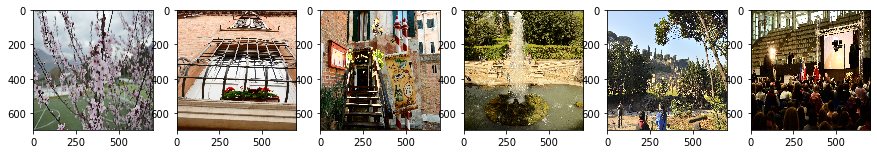

In [17]:
NB_TESTS = 3
sub_df = pd.concat([df_not_people.iloc[:NB_TESTS], df_people.iloc[:NB_TESTS]])
sub_df = sub_df.reset_index(drop=True)
labels = []

fig, axes = plt.subplots(nrows=1, ncols=2*NB_TESTS, figsize=(15,15))
plt.figure(1)
for i, row in sub_df.iterrows():
    img = image.load_img(get_file_path(row["FileName"]), target_size=IMAGE_SIZE)
    axes[i].imshow(img)
    labels.append(model.predict(preprocess_input(np.expand_dims(img, axis = 0))))

print("First" + str(NB_TESTS) + " not people, last " + str(NB_TESTS) + "  people:")
print(labels)

We don't have enough data to get useful results here (overfitting).


We can save the model.

In [19]:
model.save(MODEL_SAVE_PATH)

## Data augmentation

Here we will plot some data augmentation we can do.

In [20]:
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img

In [21]:
# Taken from https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
def generate_plot_pics(datagen,orig_img):
    dir_augmented_data = "../data/preview"
    try:
        ## if the preview folder does not exist, create
        os.mkdir(dir_augmented_data)
    except:
        ## if the preview folder exists, then remove
        ## the contents (pictures) in the folder
        for item in os.listdir(dir_augmented_data):
            os.remove(dir_augmented_data + "/" + item)

    ## convert the original image to array
    x = img_to_array(orig_img)
    ## reshape (Sampke, Nrow, Ncol, 3) 3 = R, G or B
    x = x.reshape((1,) + x.shape)
    ## -------------------------- ##
    ## randomly generate pictures
    ## -------------------------- ##
    i = 0
    Nplot = 8
    for batch in datagen.flow(x,batch_size=1,
                          save_to_dir=dir_augmented_data,
                          save_prefix="pic",
                          save_format='jpeg'):
        i += 1
        if i > Nplot - 1: ## generate 8 pictures 
            break

    ## -------------------------- ##
    ##   plot the generated data
    ## -------------------------- ##
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.02,wspace=0.01,
                    left=0,right=1,bottom=0, top=1)

    ## original picture
    ax = fig.add_subplot(3, 3, 1,xticks=[],yticks=[])        
    ax.imshow(orig_img)
    ax.set_title("original")

    i = 2
    for imgnm in os.listdir(dir_augmented_data):
        ax = fig.add_subplot(3, 3, i,xticks=[],yticks=[]) 
        img = load_img(dir_augmented_data + "/" + imgnm)
        ax.imshow(img)
        i += 1
    plt.show()


In [22]:
datagen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    validation_split=VALIDATION_RATIO,
    preprocessing_function=preprocess_input
    )

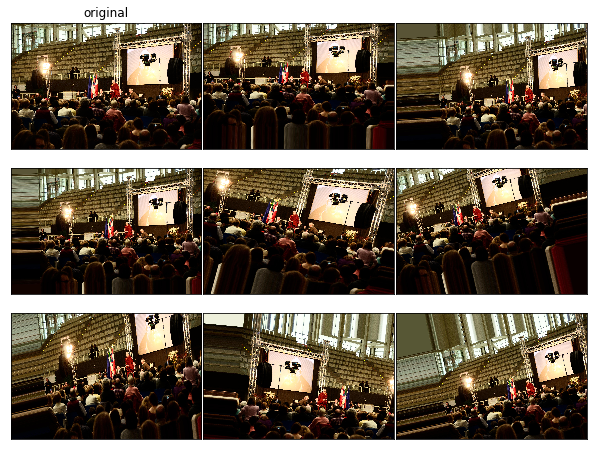

In [23]:
orig_img = load_img(get_file_path("image_r0141f0c9t.tif")) # An image with people
generate_plot_pics(datagen,orig_img)

## Inception with built-in features

Inception has built-in features, we can see what it's capable of.

In [25]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers

Let's build inception with top

In [26]:
inception_model_full = InceptionV3(weights="imagenet", include_top=True)
print("Model structure: ", inception_model_full.summary())

_____________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 17, 17, 192)  576         conv2d_157[0][0]                 
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 17, 17, 192)  576         conv2d_162[0][0]                 
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 17, 17, 192)  576         conv2d_163[0][0]                 
__________________________________________________________________________________________________
activation_154 (Activation)     (None, 17, 17, 192)  0           batch_normalization_154[0][0]    
__________________________________________________________________________________________________
activation_157 (Activation)     (None, 17, 17, 192)  0           batch_normalization_157[0][0]    
_______________

In [27]:
# Nb of layers
print("Nb of layers: ", len(inception_model_full.layers), "\n")

# Entry layer
print("Entry layer: ", inception_model_full.layers[0], " with ", inception_model_full.layers[0].input_shape, " input shape.\n")

# Last layers
print("Before last layer: ", inception_model_full.layers[-2], " with ", inception_model_full.layers[-2].output_shape, " output shape.")
print("Last layer: ", inception_model_full.layers[-1], " with ", inception_model_full.layers[-1].output_shape, " output shape.")

Nb of layers:  313 

Entry layer:  <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1b2771ba90>  with  [(None, 299, 299, 3)]  input shape.

Before last layer:  <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x1d50b46f10>  with  (None, 2048)  output shape.
Last layer:  <tensorflow.python.keras.layers.core.Dense object at 0x1d50b658d0>  with  (None, 1000)  output shape.


We can see what Inception is capable of:

[[('n03388043', 'fountain', 0.17286538), ('n04523525', 'vault', 0.100133315), ('n04429376', 'throne', 0.058088984)]]
[[('n04523525', 'vault', 0.48004085), ('n02825657', 'bell_cote', 0.086361006), ('n02708093', 'analog_clock', 0.030275203)]]
[[('n02883205', 'bow_tie', 0.9977005), ('n10148035', 'groom', 0.00034702686), ('n02791270', 'barbershop', 0.0002622916)]]
[[('n03781244', 'monastery', 0.3524693), ('n02980441', 'castle', 0.13233542), ('n03028079', 'church', 0.07052431)]]
[[('n03930313', 'picket_fence', 0.03976039), ('n07248320', 'book_jacket', 0.037148617), ('n02840245', 'binder', 0.032425724)]]


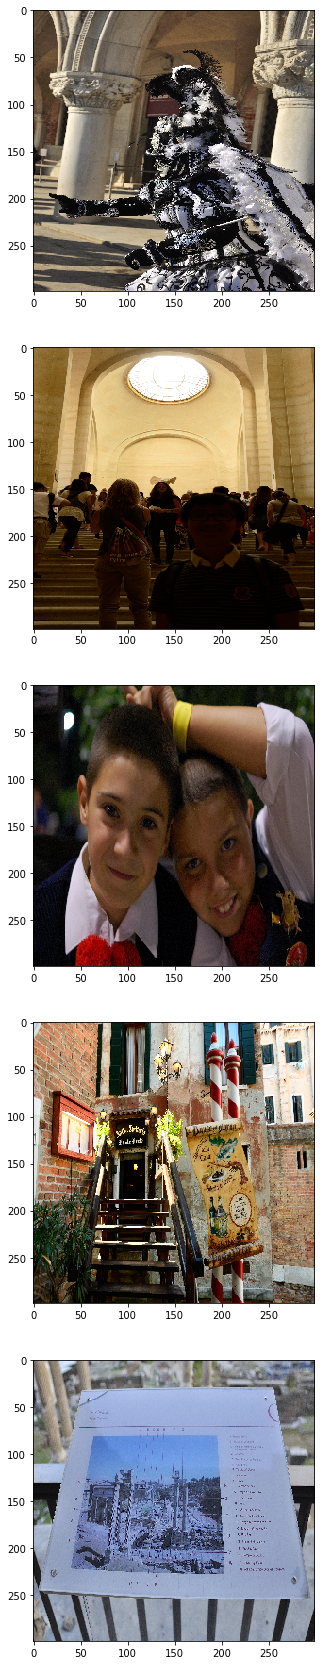

In [28]:
nb_images_to_process = 5
fig, axes = plt.subplots(nrows=nb_images_to_process, ncols=1, figsize=(30,30))
for i, row in df_final.iloc[:nb_images_to_process].iterrows():
    img = image.load_img(get_file_path(row["FileName"]), target_size=(299,299))
    axes[i].imshow(img)
    features = inception_model_full.predict(preprocess_input(np.expand_dims(img, axis = 0)))
    print(decode_predictions(features, top = 3))